In [1]:
from fast_causal_inference import FastCausalInference
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder

In [2]:
base_dir = '../../'
result_dir = base_dir + 'result/R/'
data_path = base_dir + 'dataset/' + 'Real_World_IBS.xlsx'
df = pd.read_excel(data_path)
df = df.drop(columns=['HAD_Anxiety', 'Patient', 'Batch_metabolomics', 'BH', 'Sex', 'Age', 'BMI','Race','Education','HAD_Depression','STAI_Tanxiety', 'Diet_Category','Diet_Pattern'])
label_encoder = LabelEncoder()
df['Group'] = label_encoder.fit_transform(df['Group'])
df_encoded = df

X = df_encoded.drop(columns=['Group'])
y = df_encoded['Group']

X = X[["xylose", "xanthosine", "uracil", "ribulose/xylulose", "valylglutamine",
           "tryptophylglycine", "succinate", "valine betaine", "ursodeoxycholate sulfate (1)",
           "tricarballylate", "succinimide", "thymine", "syringic acid", "serotonin", "ribitol"]]

param_dist = {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, 30, None],
        'min_samples_split': [2, 5, 7],
        'min_samples_leaf': [1, 2, 4]
    }
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestClassifier(random_state=42)
random_search = RandomizedSearchCV(
estimator=rf, param_distributions=param_dist, n_iter=50, cv=3, n_jobs=-1, verbose=2, random_state=42)
random_search.fit(X_train, y_train)
model = random_search.best_estimator_
best_params = random_search.best_params_

Fitting 3 folds for each of 50 candidates, totalling 150 fits


c:\Users\snorl\Desktop\FYP\venv\Lib\site-packages\numpy\ma\core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [3]:
base_dir = '../../'
data_path = base_dir + 'dataset/' + 'Real_World_IBS_Predicted_Probabilities.xlsx'
df_prob = pd.read_excel(data_path)
X_train['Prob_Class_1'] = df_prob['Prob_Class_1']

## Inference

In [4]:
ci = FastCausalInference(data=X_train, model=model, target_variable='Prob_Class_1')
ci.load_causal_strengths(result_dir + 'Mean_Causal_Effect_IBS.json')
x_instance = X_test.iloc[33]

In [5]:
phi = ci.compute_modified_shap_proba(x_instance, is_classifier=True)

## Eval

In [ ]:
phi = []
for i in range(len(X_test)):
    phi.append(ci.compute_modified_shap_proba(X_test.iloc[i], is_classifier=True))

phi_df = pd.DataFrame(phi)
mean_values = phi_df.abs().mean()
global_importance = mean_values.sort_values(ascending=False)

In [ ]:
from evaluation import evaluate_global_shap_scores
from sklearn.preprocessing import StandardScaler
import numpy as np


seeds = [42, 123, 456, 789, 1010]

X = X[["xylose", "xanthosine", "uracil", "ribulose/xylulose", "valylglutamine", "tryptophylglycine", "succinate", "valine betaine", "ursodeoxycholate sulfate (1)", "tricarballylate","succinimide", "thymine", "syringic acid", "serotonin", "ribitol" ]]

y = df_encoded['Group']

scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X),columns=X.columns,index=X.index)

all_scores = {
    'deletion': {
        'auroc': [],
        'cross_entropy': [],
        'brier': []
    },
    'insertion': {
        'auroc': [],
        'cross_entropy': [],
        'brier': []
    }
}

for i in seeds:
    print("Training Random Forest model...")
    param_dist = {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, 30, None],
        'min_samples_split': [2, 5, 7],
        'min_samples_leaf': [1, 2, 4]
    }
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=i)

    rf = RandomForestClassifier(random_state=42)
    random_search = RandomizedSearchCV(
    estimator=rf, param_distributions=param_dist, n_iter=50,
            cv=3, n_jobs=-1, verbose=2, random_state=42)
    random_search.fit(X_train, y_train)
    model = random_search.best_estimator_
    best_params = random_search.best_params_

    shap_values = global_importance

    result = evaluate_global_shap_scores(model, X_test, y_test, shap_values, causal=True)

    for method in ['deletion', 'insertion']:
        for metric in ['auroc', 'cross_entropy', 'brier']:
            all_scores[method][metric].append(result[method]["average_scores"][metric])


Training Random Forest model...
Fitting 3 folds for each of 50 candidates, totalling 150 fits


c:\Users\snorl\Desktop\FYP\venv\Lib\site-packages\numpy\_core\fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\snorl\Desktop\FYP\venv\Lib\site-packages\numpy\_core\_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\snorl\Desktop\FYP\venv\Lib\site-packages\numpy\_core\fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\snorl\Desktop\FYP\venv\Lib\site-packages\numpy\_core\_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Training Random Forest model...
Fitting 3 folds for each of 50 candidates, totalling 150 fits


c:\Users\snorl\Desktop\FYP\venv\Lib\site-packages\numpy\_core\fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\snorl\Desktop\FYP\venv\Lib\site-packages\numpy\_core\_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\snorl\Desktop\FYP\venv\Lib\site-packages\numpy\_core\fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\snorl\Desktop\FYP\venv\Lib\site-packages\numpy\_core\_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Training Random Forest model...
Fitting 3 folds for each of 50 candidates, totalling 150 fits


c:\Users\snorl\Desktop\FYP\venv\Lib\site-packages\numpy\_core\fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\snorl\Desktop\FYP\venv\Lib\site-packages\numpy\_core\_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\snorl\Desktop\FYP\venv\Lib\site-packages\numpy\_core\fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\snorl\Desktop\FYP\venv\Lib\site-packages\numpy\_core\_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Training Random Forest model...
Fitting 3 folds for each of 50 candidates, totalling 150 fits


c:\Users\snorl\Desktop\FYP\venv\Lib\site-packages\numpy\_core\fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\snorl\Desktop\FYP\venv\Lib\site-packages\numpy\_core\_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\snorl\Desktop\FYP\venv\Lib\site-packages\numpy\_core\fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\snorl\Desktop\FYP\venv\Lib\site-packages\numpy\_core\_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Training Random Forest model...
Fitting 3 folds for each of 50 candidates, totalling 150 fits


c:\Users\snorl\Desktop\FYP\venv\Lib\site-packages\numpy\_core\fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\snorl\Desktop\FYP\venv\Lib\site-packages\numpy\_core\_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\snorl\Desktop\FYP\venv\Lib\site-packages\numpy\_core\fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\snorl\Desktop\FYP\venv\Lib\site-packages\numpy\_core\_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [ ]:
import json
final_results = {
    'deletion': {
        metric: {
            'mean': np.mean(scores),
            'std': np.std(scores)
        }
        for metric, scores in all_scores['deletion'].items()
    },
    'insertion': {
        metric: {
            'mean': np.mean(scores),
            'std': np.std(scores)
        }
        for metric, scores in all_scores['insertion'].items()
    }
}

print("\nFinal Results:")
print(json.dumps(final_results, indent=4))


Final Results:
{
    "deletion": {
        "auroc": {
            "mean": 0.6072804297593022,
            "std": 0.033756452674940034
        },
        "cross_entropy": {
            "mean": 0.7810383556603926,
            "std": 0.04125080773121551
        },
        "brier": {
            "mean": 0.29054916153982324,
            "std": 0.018640170603287803
        }
    },
    "insertion": {
        "auroc": {
            "mean": 0.8531238679722886,
            "std": 0.01749174187306101
        },
        "cross_entropy": {
            "mean": 0.4902830011310785,
            "std": 0.02738522128428254
        },
        "brier": {
            "mean": 0.15868453686398365,
            "std": 0.011631364668156507
        }
    }
}


## Visualization

Nodes directly affecting Prob_Class_1 (sorted by effect strength):
Coriobacteriia: -0.3765
Blastocatellia: -0.3195
Clostridia: 0.2925


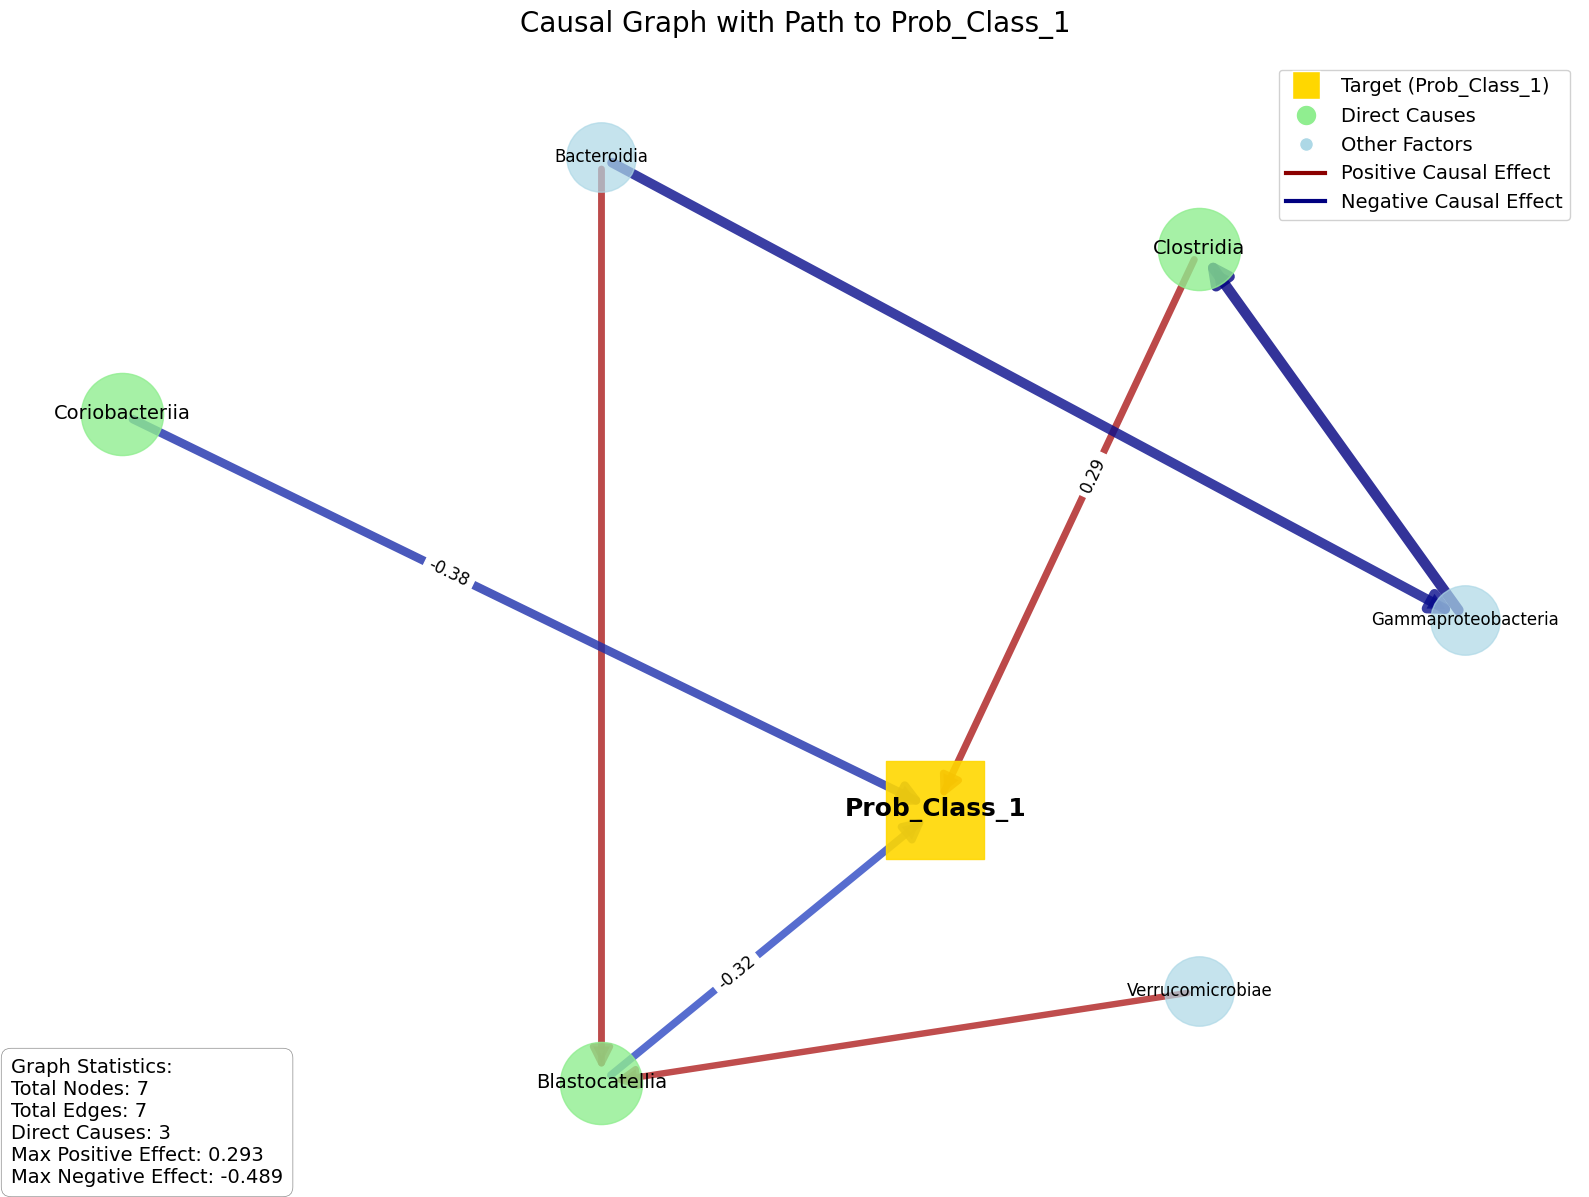

In [4]:

from visualization import visualize_causal_graph

import json
with open('../../result/R/Mean_Causal_Effect_IBS_Species_PRJNA789106_class_pivoted.json', 'r') as f:
    causal_data = json.load(f)

G, stats = visualize_causal_graph(
    causal_data,
    target_node="Prob_Class_1",
    min_effect_threshold=0,
    figsize=(16, 12),
    layout_type="circular"
)